Get the data on fragments of glass
collected in forensic work from the book website.
Estimate the density of the first variable
(refractive index) using a histogram and
a kernel density estimator.
Use cross-validation to choose the amount of smoothing.
Experiment with different binwidths and bandwiths.
Comment on the similarities and differences.
Construct 95 percent confidence bands for your estimators.

The data may be found at https://www.stat.cmu.edu/~larry/all-of-statistics/=data/glass.dat

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

In [6]:
# Read the data into a pandas data frame
glass_df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the single dataframe column into a numpy array
glass_data = glass_df['RI'].to_numpy()

# Histogram estimator

In `HistogramEstimator.cv_risk` below the cross-validation estimate of the risk is computed using the identity
$$
    \hat J (m) = \frac{2m}{n-1} - \frac{m(n+1)}{n-1} \sum_{j=1}^m \hat p_j
$$
(recall that $m = 1 / h$).

In [2]:
class HistogramEstimator():
    """
    An histogram estimator.
    
    Attributes
    bin_edges        1D array: the edges of the histogram's bins
    bin_width        float:    the width of each bin
                               (the bins all have equal width)
    counts           1D array: the number of sample points in each bin
    data             1D array: the sample points
    density          1D array: the value of the density in each bin
    number_of_bins   integer:  the number of bins
    values_p_j       1D array: the value of p_j in each bin
    lower_bound      HistogramEstimator: lower bound of a confidence band
    upper_bound      HistogramEstimator: upper bound of a confidence band
                               
    Methods
    create_confidence_band        Create two other histogram estimators
                                  constituting a confidence band
    copy_with_new_density  
    cv_risk                       Evaluate the cross-validation risk
    plot                          Plot the histogram estimator
    """
    
    def __init__(self, number_of_bins, data):
        """
        To initialize a HistogramEstimator object we only need
        to provide the arguments number_of_bins and data.
        The other attributes of the HistogramEstimator
        are automatically computed in terms of those.
        """
        self.number_of_bins = number_of_bins
        self.data = data
        
        self.counts, self.bin_edges = np.histogram(data, number_of_bins)
        self.bin_width = np.diff(self.bin_edges)[0]
        self.values_p_j = self.counts/data.shape[0]
        self.density = self.values_p_j/self.bin_width
        
        self.lower_bound = None
        self.upper_bound = None
        
    def create_confidence_band(self, alpha=0.05):
        """
        Create a (1 - alpha) confidence band for the histogram estimator.
        This is done by populating the arguments lower_bound and upper_bound
        of the HistogramEstimator object.

        Arguments:
        alpha        Number between 0 and 1
        """

        m = self.number_of_bins
        n = self.data.shape[0]
        
        c = (1/2)*scipy.stats.norm.isf(alpha/(2*m))*np.sqrt(m/n)
        
        # Copy the histogram object to create its lower and upper bounds
        self.lower_bound = HistogramEstimator(self.number_of_bins, self.data)
        self.upper_bound = HistogramEstimator(self.number_of_bins, self.data)
        
        # Update the densities of the lower and upper bounds
        self.lower_bound.density = np.maximum(np.sqrt(self.density) - c, 0)**2
        self.upper_bound.density = (np.sqrt(self.density) + c)**2
        
        # Set the data attributes of the lower and upper bounds to None
        # (since these HistogramEstimator objects are no longer computed from data)
        # and update the p_j values according to the new density
        for bound in (self.lower_bound, self.upper_bound):
            bound.data = None
            bound.values_p_j = bound.density * bound.bin_width
        
    def cv_risk(self):
        """
        Evaluate the leave-one-out cross-validation
        estimate of the histogram risk.
        """
        
        m = self.number_of_bins
        n = self.data.shape[0]
        
        return m/(n-1)*(2 - (n+1)*np.sum(self.values_p_j**2))
    
    def plot(self, axis, label=None):
        """
        Plot the histogram estimator on the given axis object.
        
        Passing the axis object as an argument makes it possible
        to plot different histogram estimators in subplots.
        """
        if label is not None:
            label_text = label
        else:
            label_text = f"m = {self.number_of_bins}"
        axis.bar(self.bin_edges[:-1], self.density, width=self.bin_width, align='edge', label=label_text)
    
def create_cv_risk_list(data, plot_flag=False):
    """
    Given a 1D array data, take m ranging
    from 1 to the number of samples and,
    for each, compute the cross-validation risk.
    
    Return both m_list, cv_risk_list,
    to make subsequent plotting easier, 
    as well as the optimal m (which minimizes
    the cross-validation risk).
    
    Plot the result, if asked.
    """
    
    n = data.shape[0]
    m_list = np.arange(1, n)
    
    cv_risk_function = lambda m : HistogramEstimator(m, data).cv_risk()
    cv_risk_list = np.vectorize(cv_risk_function)(m_list)
    m_optimal = m_list[cv_risk_list.argmin()]
    
    if plot_flag:
        plt.plot(m_list, cv_risk_list, label='Cross-validation risk as a function of the number of bins')
        plt.legend(loc='best')
        plt.show()
        plt.close()
    
    return m_list, cv_risk_list, m_optimal

## Carrying out the histogram estimation

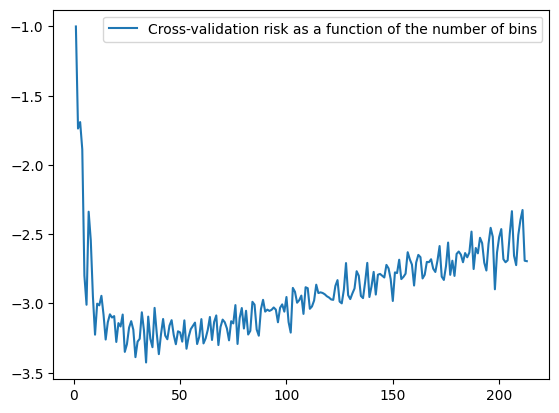

The optimal number of bins (per cross-validation) is 34.


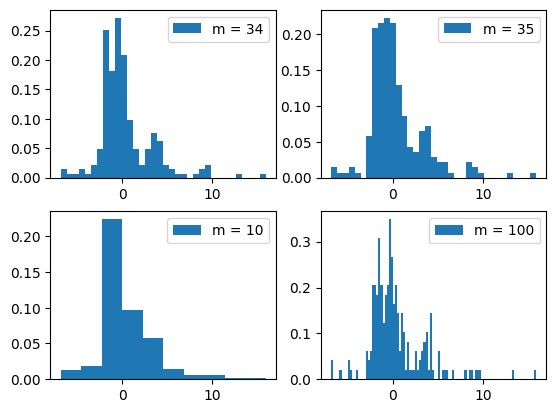

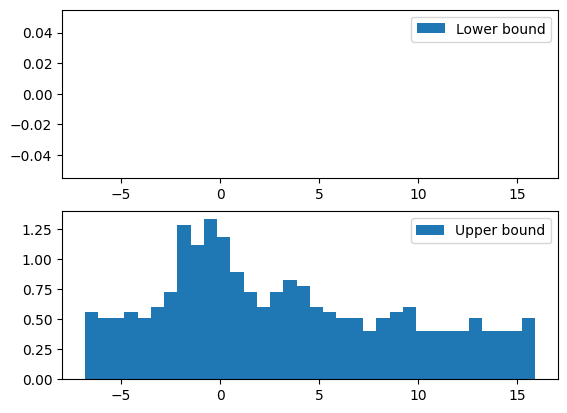

In [8]:
# Find the optimal number of bins (per cross-validation)
# and plot the cross-validation as a function of the bin width
_, _, m_optimal = create_cv_risk_list(glass_data, plot_flag=True)
print(f"The optimal number of bins (per cross-validation) is {m_optimal}.")

# Plot histograms with several bin widths
m_list = [34, 35, 10, 100]
fig, axs = plt.subplots(2, 2)
for axis, m in list(zip(axs.reshape(4), m_list)):
    HistogramEstimator(m, glass_data).plot(axis)
    axis.legend(loc='best')
plt.show()
plt.close()

# Plot the confidence band
histest = HistogramEstimator(m_optimal, glass_data)
histest.create_confidence_band()
fig, axs = plt.subplots(2)
for axis, bound, label_text in (
    (axs[0], histest.lower_bound, 'Lower bound'),
    (axs[1], histest.upper_bound, 'Upper bound'),
):
    bound.plot(axis, label=label_text)
    axis.legend(loc='best')

## Histogram estimation - Summary of results

We observe the following.
1. When the number of bins is too small
   (i.e. the binwidth is too large, or equivalently
   the amount of smoothing is too high)
   some features are erased.
   For example the twin peaks around zero merge into one when m = 10.
1. When the number of bins is too large
   (i.e. the binwidth is too small, or equivalently
   the amount of smoothing is too low)
   some features appear which may be artifacts of the sample,
   and not of the underlying distribution.
   We see this in the histogram with m = 100 above.
1. Even when the number of bins is **very close**
   to the optimal number of bins, the features of
   the resulting histogram estimator may vary significantly.
   For example the twin peaks near zero are visible when m = 34,
   which is optimal, but merge when m = 35.
   This is because the leave-one-out cross-validation
   estimate of the histogram risk has significant oscillations.
1. The confidence band above is **very large**
   (the lower bound is uniformly 0!)
   With 214 data points, we have little guarantee
   that the histogram estimator is close to the true density.